# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

In [2]:
%matplotlib inline

In [3]:
dataset = get_dataset("/home/workspace/nd013-c1-vision-starter/data/train/*")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/nd013-c1-vision-starter/data/train/*']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/nd013-c1-vision-starter/data/train/*']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [4]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    
    # color mapping of classes
    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}

    f, ax = plt.subplots(2, 5, figsize=(20, 10))
    
    for idx,example in enumerate(batch):
        x = idx % 2
        y = idx % 5
        print(example.keys())
    
        im_width, im_height = example["original_image_spatial_shape"]
    
        ax[x, y].imshow(example["image"].numpy())
        print(example["image"].shape)
    
        bboxes  = example["groundtruth_boxes"]
        classes = example["groundtruth_classes"]
        print(example["original_image_spatial_shape"])
        print(classes)
        for cl, bb in zip(classes, bboxes):
            y1, x1, y2, x2 = bb.numpy()
            (x1, x2, y1, y2) = (x1 * im_width.numpy(),  x2 * im_width.numpy(),\
                                y1 * im_height.numpy(), y2 * im_height.numpy())
            print(y1,x1,y2,x2)
            #x1, y1, x2, y2 = bb.numpy()
            rec = Rectangle((x1, y1), (x2-x1), (y2-y1), facecolor='none', 
                            edgecolor=colormap[cl.numpy()])
            ax[x, y].add_patch(rec)
        #ax[x ,y].axis('off')
            
    plt.tight_layout()
    plt.show()

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

dict_keys(['image', 'source_id', 'key', 'filename', 'groundtruth_image_confidences', 'groundtruth_verified_neg_classes', 'groundtruth_not_exhaustive_classes', 'groundtruth_boxes', 'groundtruth_area', 'groundtruth_is_crowd', 'groundtruth_difficult', 'groundtruth_group_of', 'groundtruth_weights', 'groundtruth_classes', 'groundtruth_image_classes', 'original_image_spatial_shape'])
(640, 640, 3)
tf.Tensor([640 640], shape=(2,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(14,), dtype=int64)
327.6373291015625 386.11202239990234 357.63782501220703 416.84940338134766
299.68944549560547 421.16527557373047 537.7988815307617 627.2741317749023
337.9006576538086 409.1650390625 379.5855712890625 442.21824645996094
325.42675018310547 254.21497344970703 372.4802017211914 283.0575942993164
322.7425003051758 268.32048416137695 362.53265380859375 292.53143310546875
346.11133575439453 432.2180938720703 381.4803695678711 444.0077590942383
410.37559509277344 0.0 609.6422576904297 173.792514

333.9137649536133 101.94893836975098 353.8878631591797 136.7916774749756
326.6899108886719 395.9016799926758 346.5850067138672 409.5861053466797
326.2162399291992 344.4270706176758 354.0061950683594 364.63794708251953
332.69004821777344 362.42740631103516 340.5849075317383 365.16429901123047
325.7425308227539 375.0592041015625 335.53218841552734 380.3224563598633
348.2033920288086 399.5068359375 410.65174102783203 459.5603561401367
332.84793853759766 494.6402359008789 380.21717071533203 590.4313659667969
335.69007873535156 344.7428894042969 338.84803771972656 347.4797821044922
344.53235626220703 599.7999572753906 418.42838287353516 639.8006820678711
dict_keys(['image', 'source_id', 'key', 'filename', 'groundtruth_image_confidences', 'groundtruth_verified_neg_classes', 'groundtruth_not_exhaustive_classes', 'groundtruth_boxes', 'groundtruth_area', 'groundtruth_is_crowd', 'groundtruth_difficult', 'groundtruth_group_of', 'groundtruth_weights', 'groundtruth_classes', 'groundtruth_image_clas

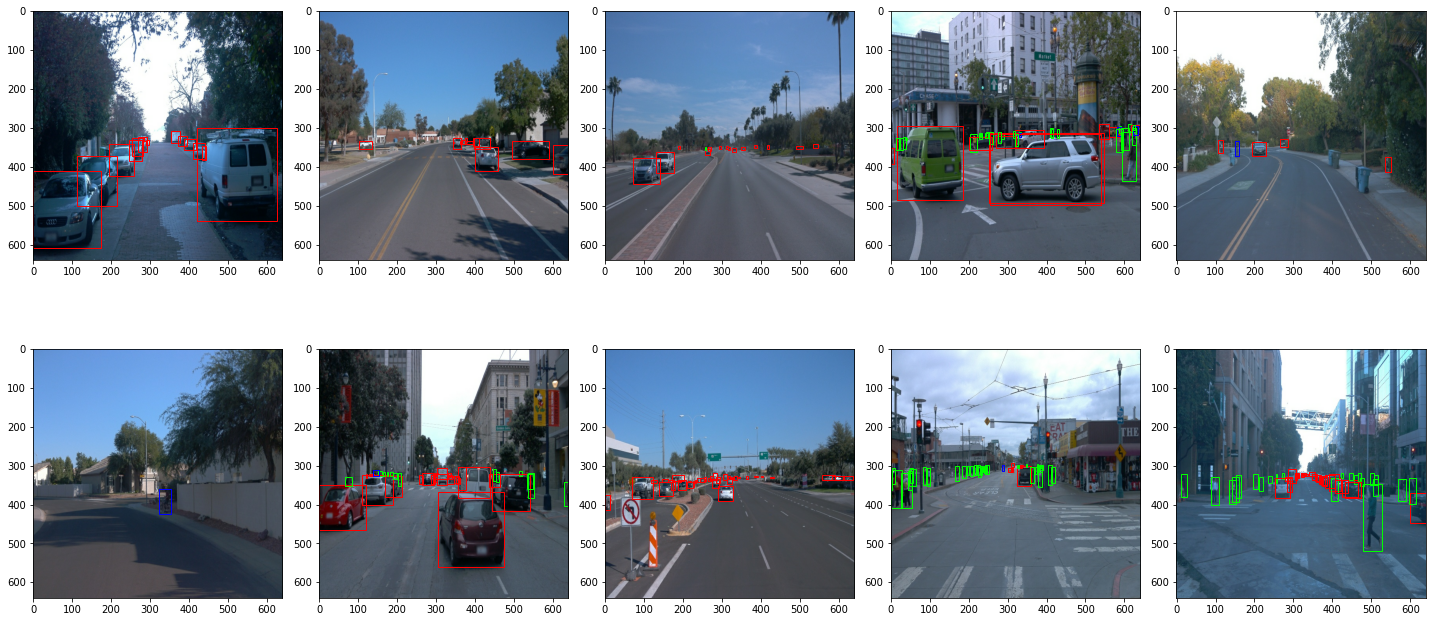

In [5]:
batch_size = 10
batch = dataset.shuffle(100)
batch = batch.take(batch_size)

display_instances(batch)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [6]:
import io
import os

import tensorflow.compat.v1 as tf
from PIL import Image
from waymo_open_dataset import dataset_pb2 as open_dataset

from utils import parse_frame, int64_feature, int64_list_feature, bytes_feature \
    bytes_list_feature, float_list_feature


def create_tf_example(filename, encoded_jpeg, annotations):
    """
    convert to tensorflow object detection API format
    args:
    - filename [str]: name of the image
    - encoded_jpeg [bytes-likes]: encoded image
    - annotations [list]: bboxes and classes
    returns:
    - tf_example [tf.Example]
    """
    encoded_jpg_io = io.BytesIO(encoded_jpeg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    mapping = {1: 'vehicle', 2: 'pedestrian', 4: 'cyclist'}
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []
    filename = filename.encode('utf8')

    for ann in annotations:
        xmin, ymin = ann.box.center_x - 0.5 * ann.box.length, 
                     ann.box.center_y - 0.5 * ann.box.width
        xmax, ymax = ann.box.center_x + 0.5 * ann.box.length,  
                     ann.box.center_y + 0.5 * ann.box.width
        xmins.append(xmin / width)
        xmaxs.append(xmax / width)
        ymins.append(ymin / height)
        ymaxs.append(ymax / height)    
        classes.append(ann.type)
        classes_text.append(mapping[ann.type].encode('utf8'))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': int64_feature(height),
        'image/width': int64_feature(width),
        'image/filename': bytes_feature(filename),
        'image/source_id': bytes_feature(filename),
        'image/encoded': bytes_feature(encoded_jpeg),
        'image/format': bytes_feature(image_format),
        'image/object/bbox/xmin': float_list_feature(xmins),
        'image/object/bbox/xmax': float_list_feature(xmaxs),
        'image/object/bbox/ymin': float_list_feature(ymins),
        'image/object/bbox/ymax': float_list_feature(ymaxs),
        'image/object/class/text': bytes_list_feature(classes_text),
        'image/object/class/label': int64_list_feature(classes),
    }))
    return tf_example


def process_tfr(path):
    """
    process a waymo tf record into a tf api tf record
    """
    # create processed data dir
    file_name = os.path.basename(path)

    logger.info(f'Processing {path}')
    writer = tf.python_io.TFRecordWriter(f'{dest}/{file_name}')
    dataset = tf.data.TFRecordDataset(path, compression_type='')
    for idx, data in enumerate(dataset):
        frame = open_dataset.Frame()
        frame.ParseFromString(bytearray(data.numpy()))
        encoded_jpeg, annotations = parse_frame(frame)
        filename = file_name.replace('.tfrecord', f'_{idx}.tfrecord')
        tf_example = create_tf_example(filename, encoded_jpeg, annotations)
        writer.write(tf_example.SerializeToString())
    writer.close()

SyntaxError: invalid syntax (<ipython-input-6-b88a829918b4>, line 9)